## House Price Modeling Project

Narmin Mammadova 438408

Dataset - https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

## Import the libraries

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder

from category_encoders import OneHotEncoder

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [3]:
train = pd.read_csv('/Users/narminmammadova/Desktop/Final Project/train.csv')
test = pd.read_csv('/Users/narminmammadova/Desktop/Final Project/test.csv')

In [4]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
train.shape

(1460, 81)

In [6]:
#Drop ID column
train.drop(["Id"], axis=1, inplace=True)
test_ids = test["Id"].values
test.drop(["Id"], axis=1, inplace=True)

## Data Exploration and Preprocessing

## 1. Investigate TARGET value distribution

SalePrice is our target variable.

In [7]:
train['SalePrice'].describe().round(1)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

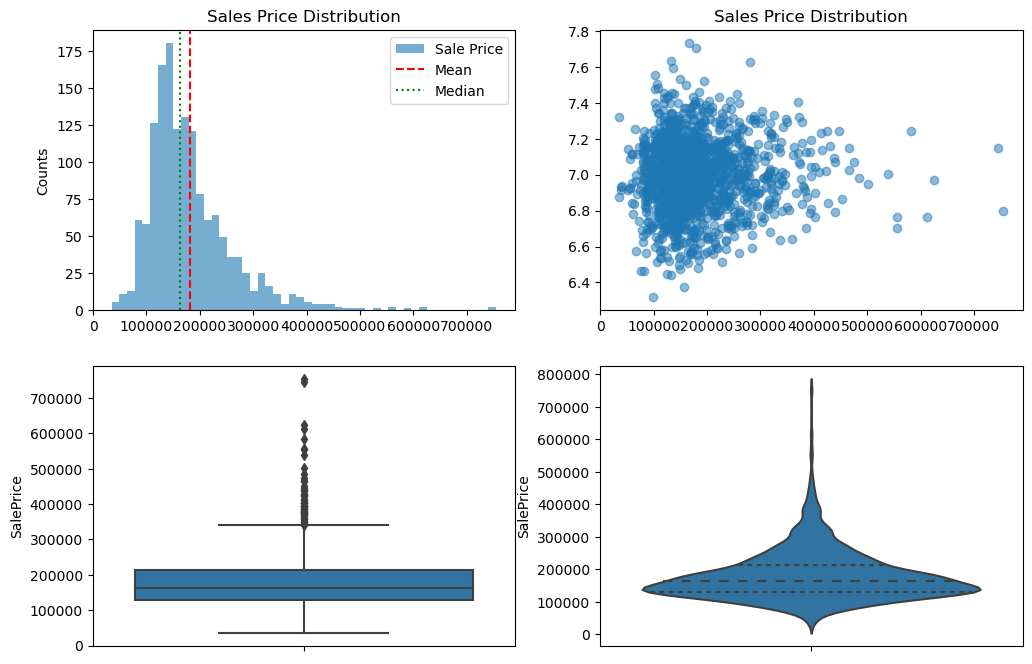

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
train['SalePrice'].hist(bins=50, label='Sale Price', alpha=0.6, grid = False)
plt.axvline(np.mean(train['SalePrice']), ls='--', c='r', label="Mean")
plt.axvline(np.median(train['SalePrice']), ls=':', c='g', label="Median")
plt.ylabel("Counts")
plt.title("Sales Price Distribution")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(train['SalePrice'], np.random.normal(7, 0.2, size=train.shape[0]), alpha=0.5)
plt.title("Sales Price Distribution")

plt.subplot(2, 2, 3)
sns.boxplot(y="SalePrice", data=train)

plt.subplot(2, 2, 4)
sns.violinplot(y="SalePrice", data=train, inner="quartile", bw=0.2)
plt.show()

Note: Target is is continuous, and the distribution is skewed to the right. Mostly house price ranges from 100,000 to 200,000

## 2. Investigate Data Types

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Some variables, such as YearBuilt, YearRemodAdd, GarageYrBlt, YrSold, MoSold are numeric variables, which is related to the year.
Some variables have a lot of null value, it can be cleaned.

Explore the categorical variables

In [10]:
cat_vars = [var 
            for var in train.columns 
            if train[var].dtype == 'O']
cat_vars

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

MSSubClass is also categorical by definition, despite its numeric values. MSSubClass should be added to the list of categorical variables

In [11]:
cat_vars = cat_vars + ['MSSubClass']

In [12]:
len(cat_vars)

44

In [13]:
train[cat_vars] = train[cat_vars].astype('O')

In [14]:
train[cat_vars].describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


Explore the continues variables

In [15]:
stat_cont = train.describe(exclude=['object']).T
stat_cont

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


In [16]:
# Drop all categorical features for exploring continues variables
tr_cont = train.copy()

for i in tr_cont.columns:
    if tr_cont[i].dtype=="object":
        tr_cont.drop(i, axis=1, inplace=True)
tr_cont.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000


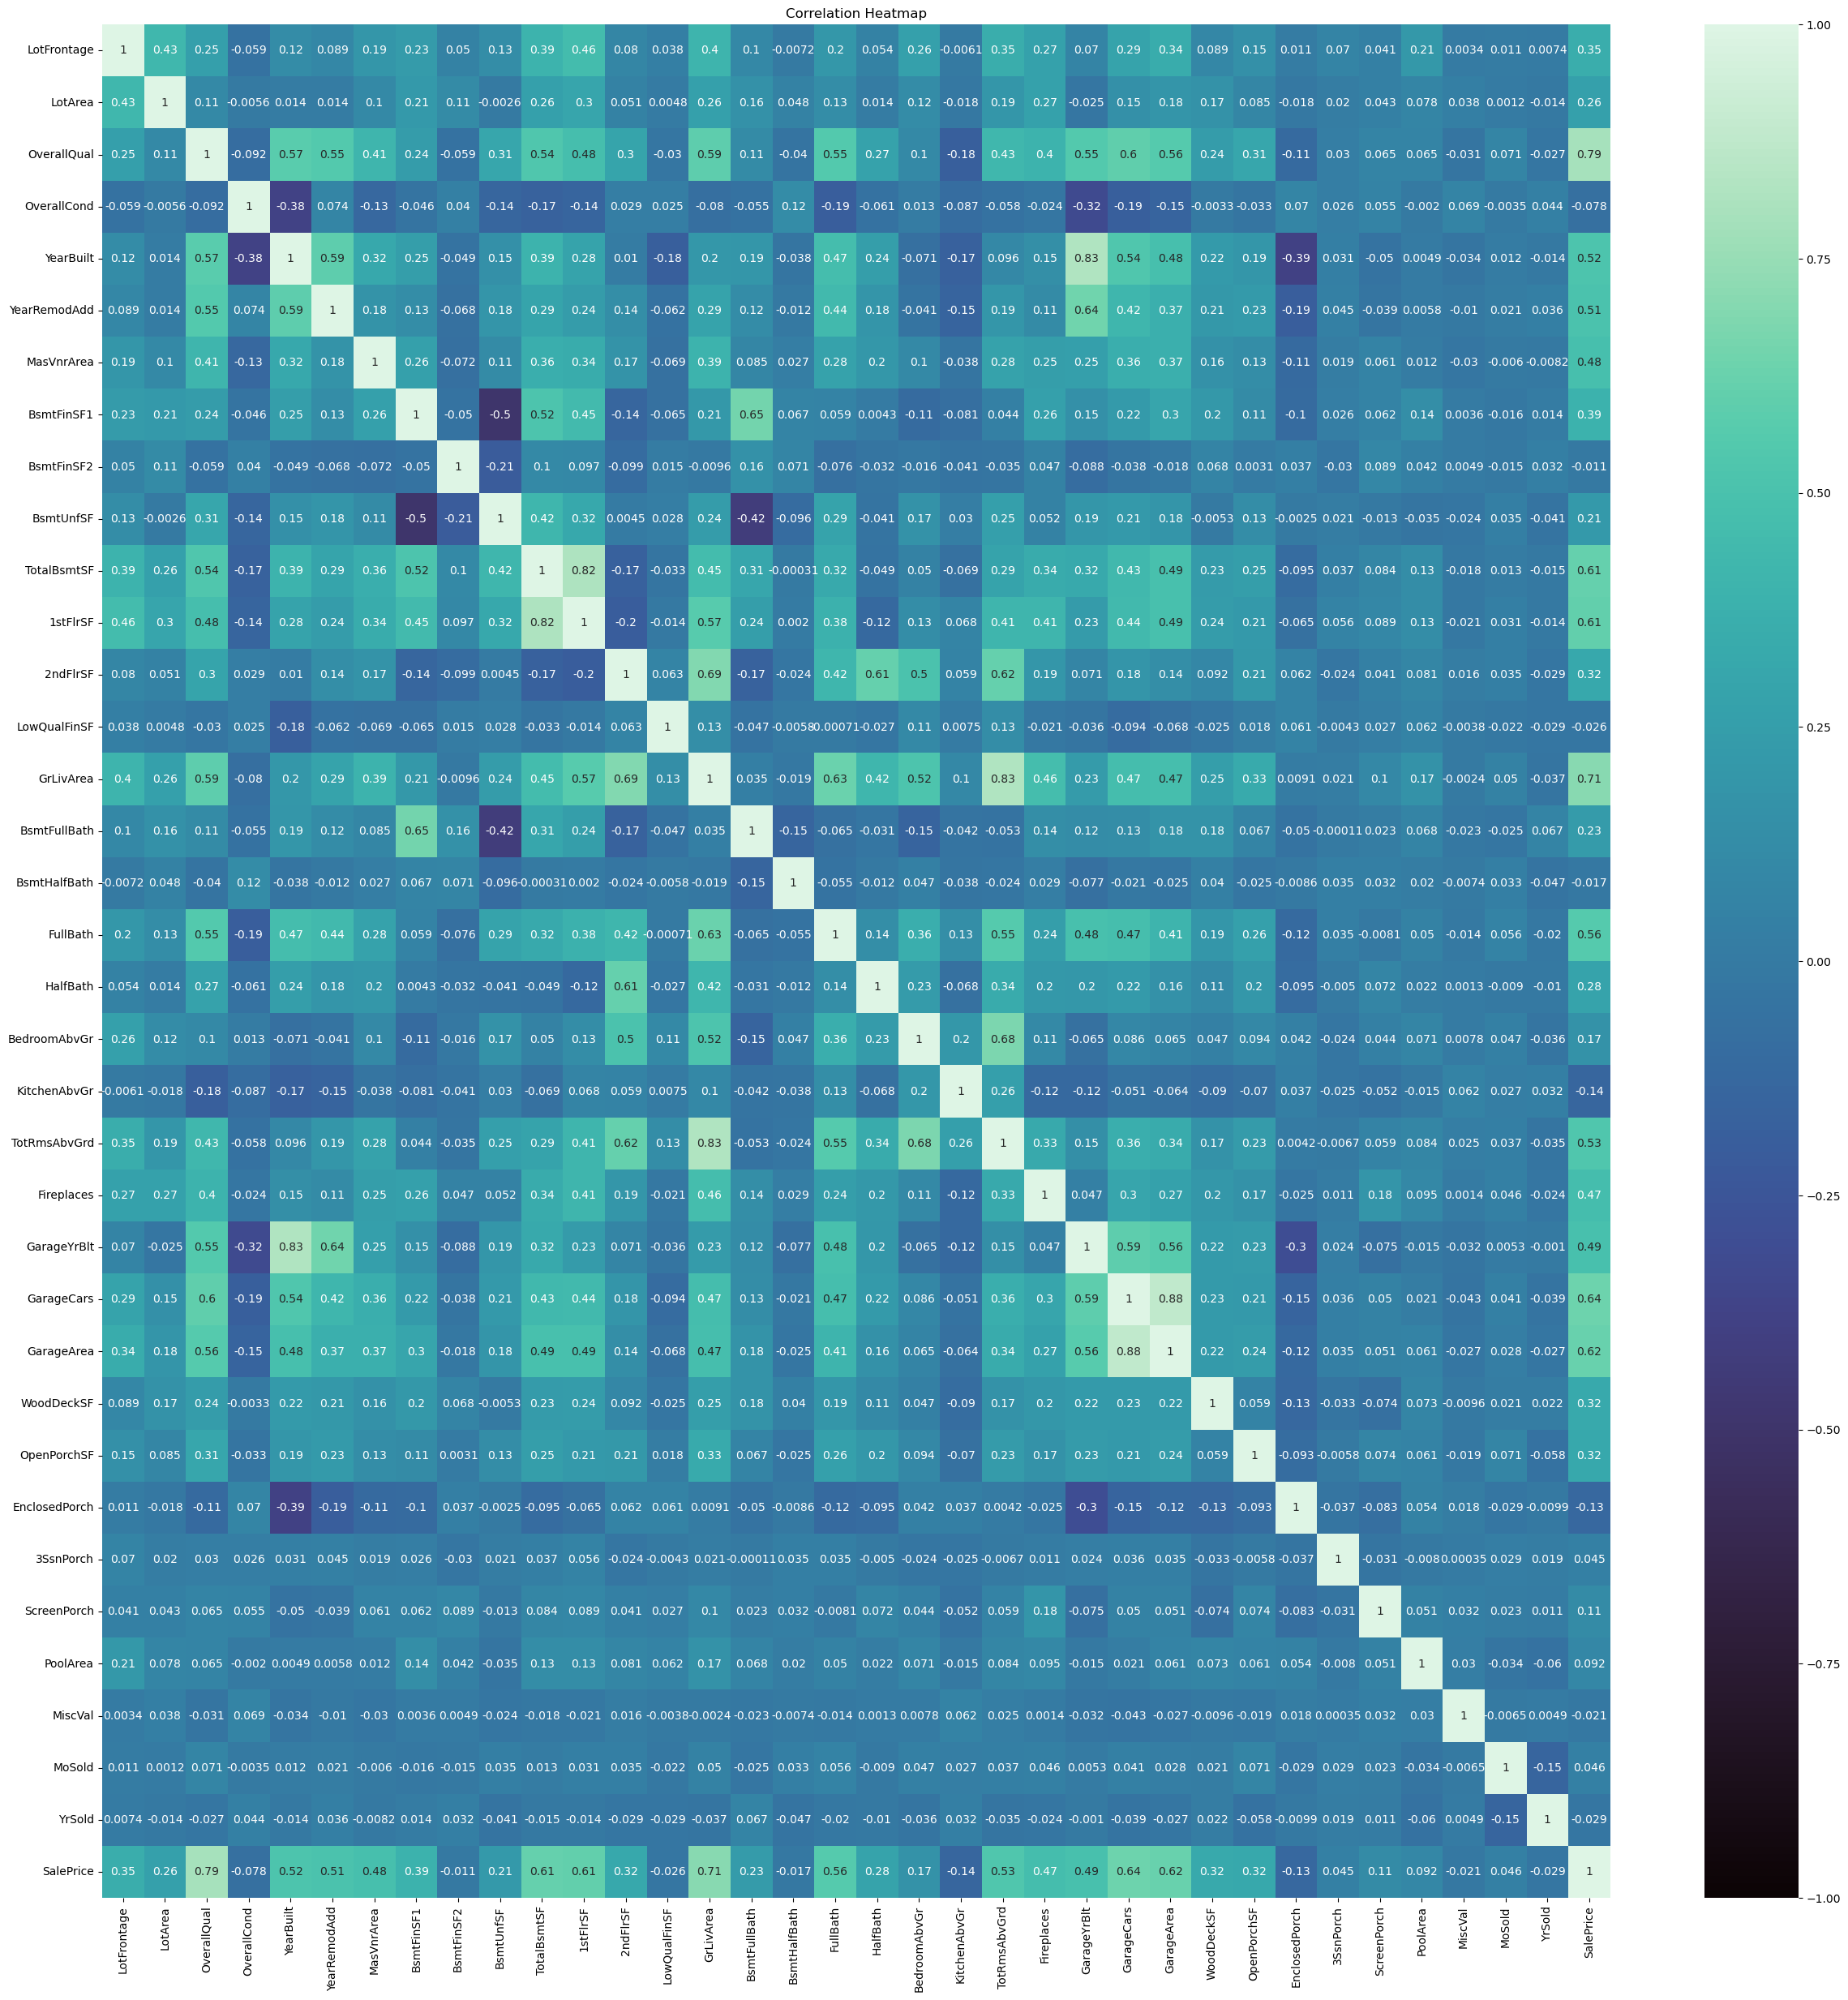

In [17]:
corr = tr_cont.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Heatmap')
plt.show()

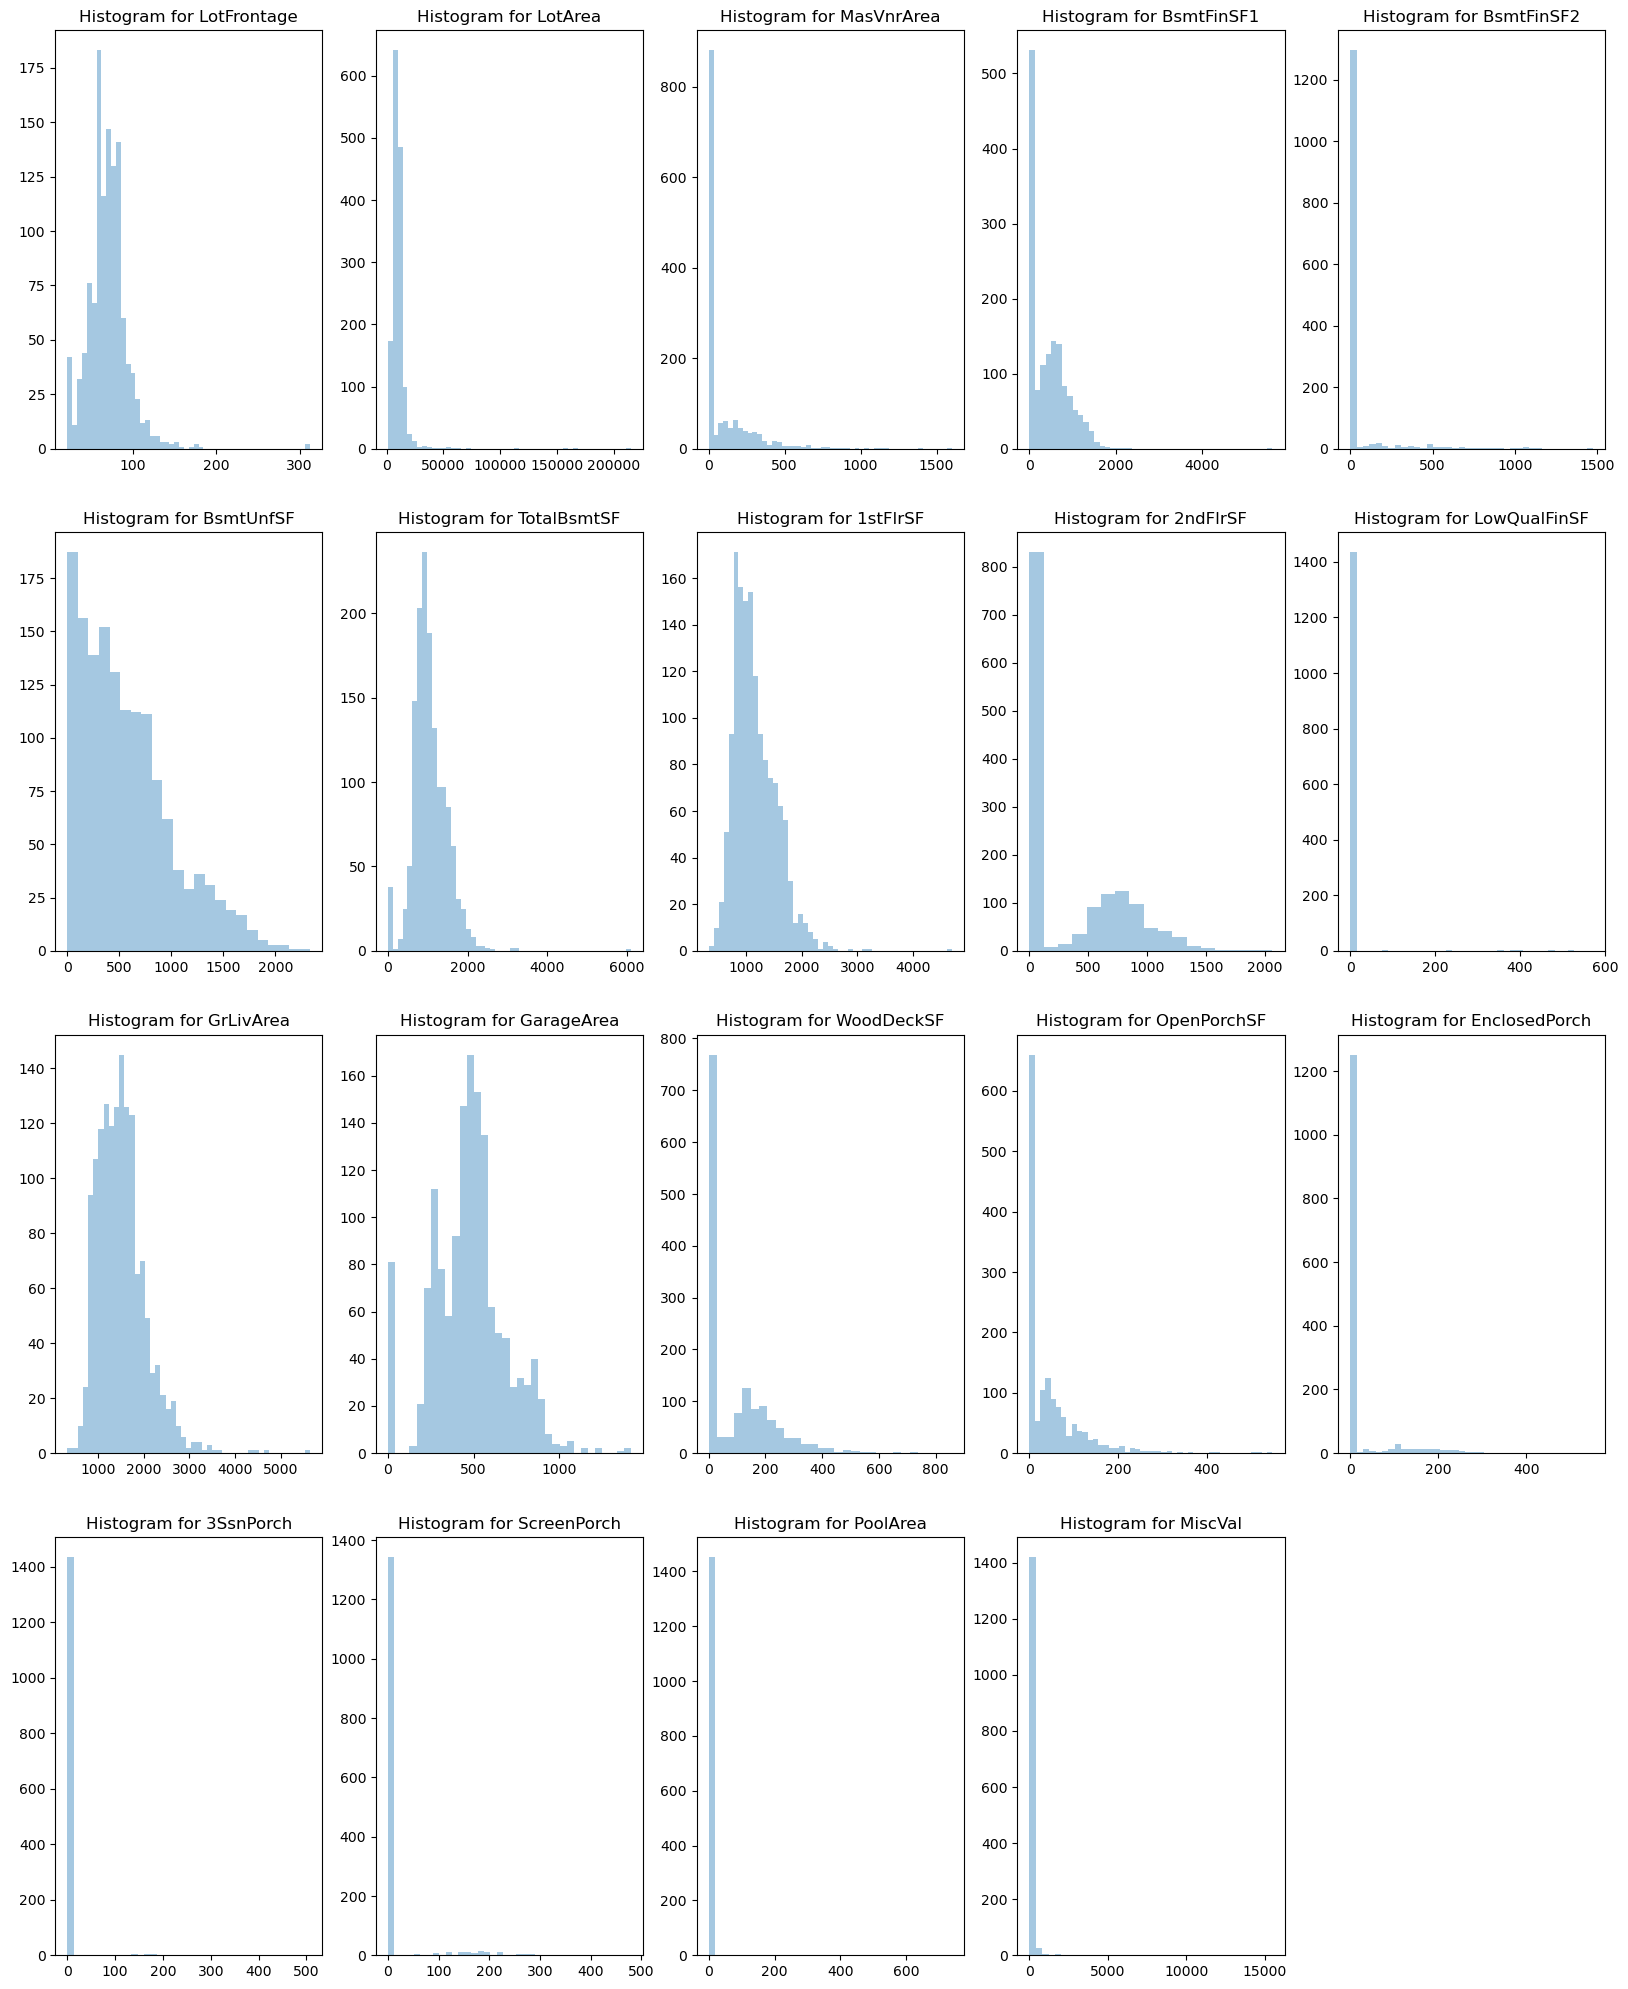

In [18]:
%matplotlib inline
# Plot histograms for continuous features
plt.figure(figsize=(20,25))
col = 1

for i in tr_cont.columns:
    if i not in ["Id","OverallQual","OverallCond",
                 "YearBuilt","YearRemodAdd","BsmtFullBath",
                 "BsmtHalfBath","FullBath","HalfBath",
                 "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd",
                 "Fireplaces","GarageYrBlt","GarageCars","MoSold","YrSold","SalePrice"]:
        if col<21:
            plt.subplot(4,5,col)
            sns.distplot(x=tr_cont[i], kde=False)
            plt.title("Histogram for %s" % (i))
        col += 1

## 3. Data Cleaning¶

In [19]:
# Check the missing values for train dataset
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
MSSubClass         0
dtype: int64

In [20]:
# Check the missing values for test dataset
test.isnull().sum().sort_values(ascending=False).head(35)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageFinish      78
GarageQual        78
GarageCond        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
SaleType           1
BsmtFinSF1         1
GarageCars         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
GarageArea         1
BsmtFinSF2         1
TotRmsAbvGrd       0
KitchenAbvGr       0
dtype: int64

Note: For both dataset some variables have a lot missing values: PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage

In [21]:
#Drop PoolQC column
train.drop(["PoolQC"], axis=1, inplace=True)
test_ids = test["PoolQC"].values
test.drop(["PoolQC"], axis=1, inplace=True)

Fill the missing variables for the categorical variables:

In [22]:
# Fill in missing values for the Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, 
# BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence and MiscFeature features
obj_NA = ["Alley","BsmtQual","BsmtCond","BsmtExposure",
          "BsmtFinType1","BsmtFinType2","FireplaceQu",
          "GarageType","GarageFinish","GarageQual",
          "GarageCond","Fence","MiscFeature"]

for i in obj_NA:
    train[i].fillna("NA", inplace=True)
    test[i].fillna("NA", inplace=True)

In [23]:
# Fill in missing values for the MSZoning, MasVnrType, Electrical, KitchenQual, Functional and SaleType 
obj_mode = ["MSZoning","MasVnrType","Electrical","KitchenQual","Functional","SaleType"]
train["MSZoning"] = train["MSZoning"].replace("C (all)","C")
test["MSZoning"] = test["MSZoning"].replace("C (all)","C")

for i in obj_mode:
    train[i].fillna(train[i].mode()[0], inplace=True)
    test[i].fillna(test[i].mode()[0], inplace=True)

In [24]:
# Fill in missing values for the Utilities feature
test["Utilities"].fillna("NoSeWa", inplace=True)

In [25]:
# Fill in missing values for the Exterior1st feature
test["Exterior1st"].fillna("ImStucc", inplace=True)
# Fill in missing values for the Exterior2nd feature
test["Exterior2nd"].fillna("Other", inplace=True)

Clean continues variables:

Fill missing variables

In [26]:
# Fill in missing values for the LotFrontage and MasVnrArea features
obj_median = ["LotFrontage","MasVnrArea"]

for i in obj_median:
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(test[i].median(), inplace=True)

In [27]:
# Fill in missing values for the BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars and GarageArea features
obj_mode = ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars","GarageArea"]

for i in obj_mode:
    test[i].fillna(test[i].mode()[0], inplace=True)

In [28]:
# Fill in missing values for the GarageYrBlt feature
train["GarageYrBlt"] = train["GarageYrBlt"].combine_first(train["YearBuilt"])
test["GarageYrBlt"] = test["GarageYrBlt"].combine_first(test["YearBuilt"])

In [29]:
# Converting dtype to 'int64'
int_list = ["LotFrontage","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageYrBlt","GarageCars","GarageArea"]

for i in int_list:
    train[i] = train[i].astype("int64")
    test[i] = test[i].astype("int64")

In [30]:
train.shape

(1460, 79)

## Feature Selection

## 1. Correlation Analysis

In [31]:
# Find correlation with the target and sort
correlations = train.corr()['SalePrice'].sort_values()

# Display correlations
print('Most Postive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Postive Correlations:
 YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

Most Negative Correlations:
 KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
Name: SalePrice, dtype: float64


## Area vs Sale Price

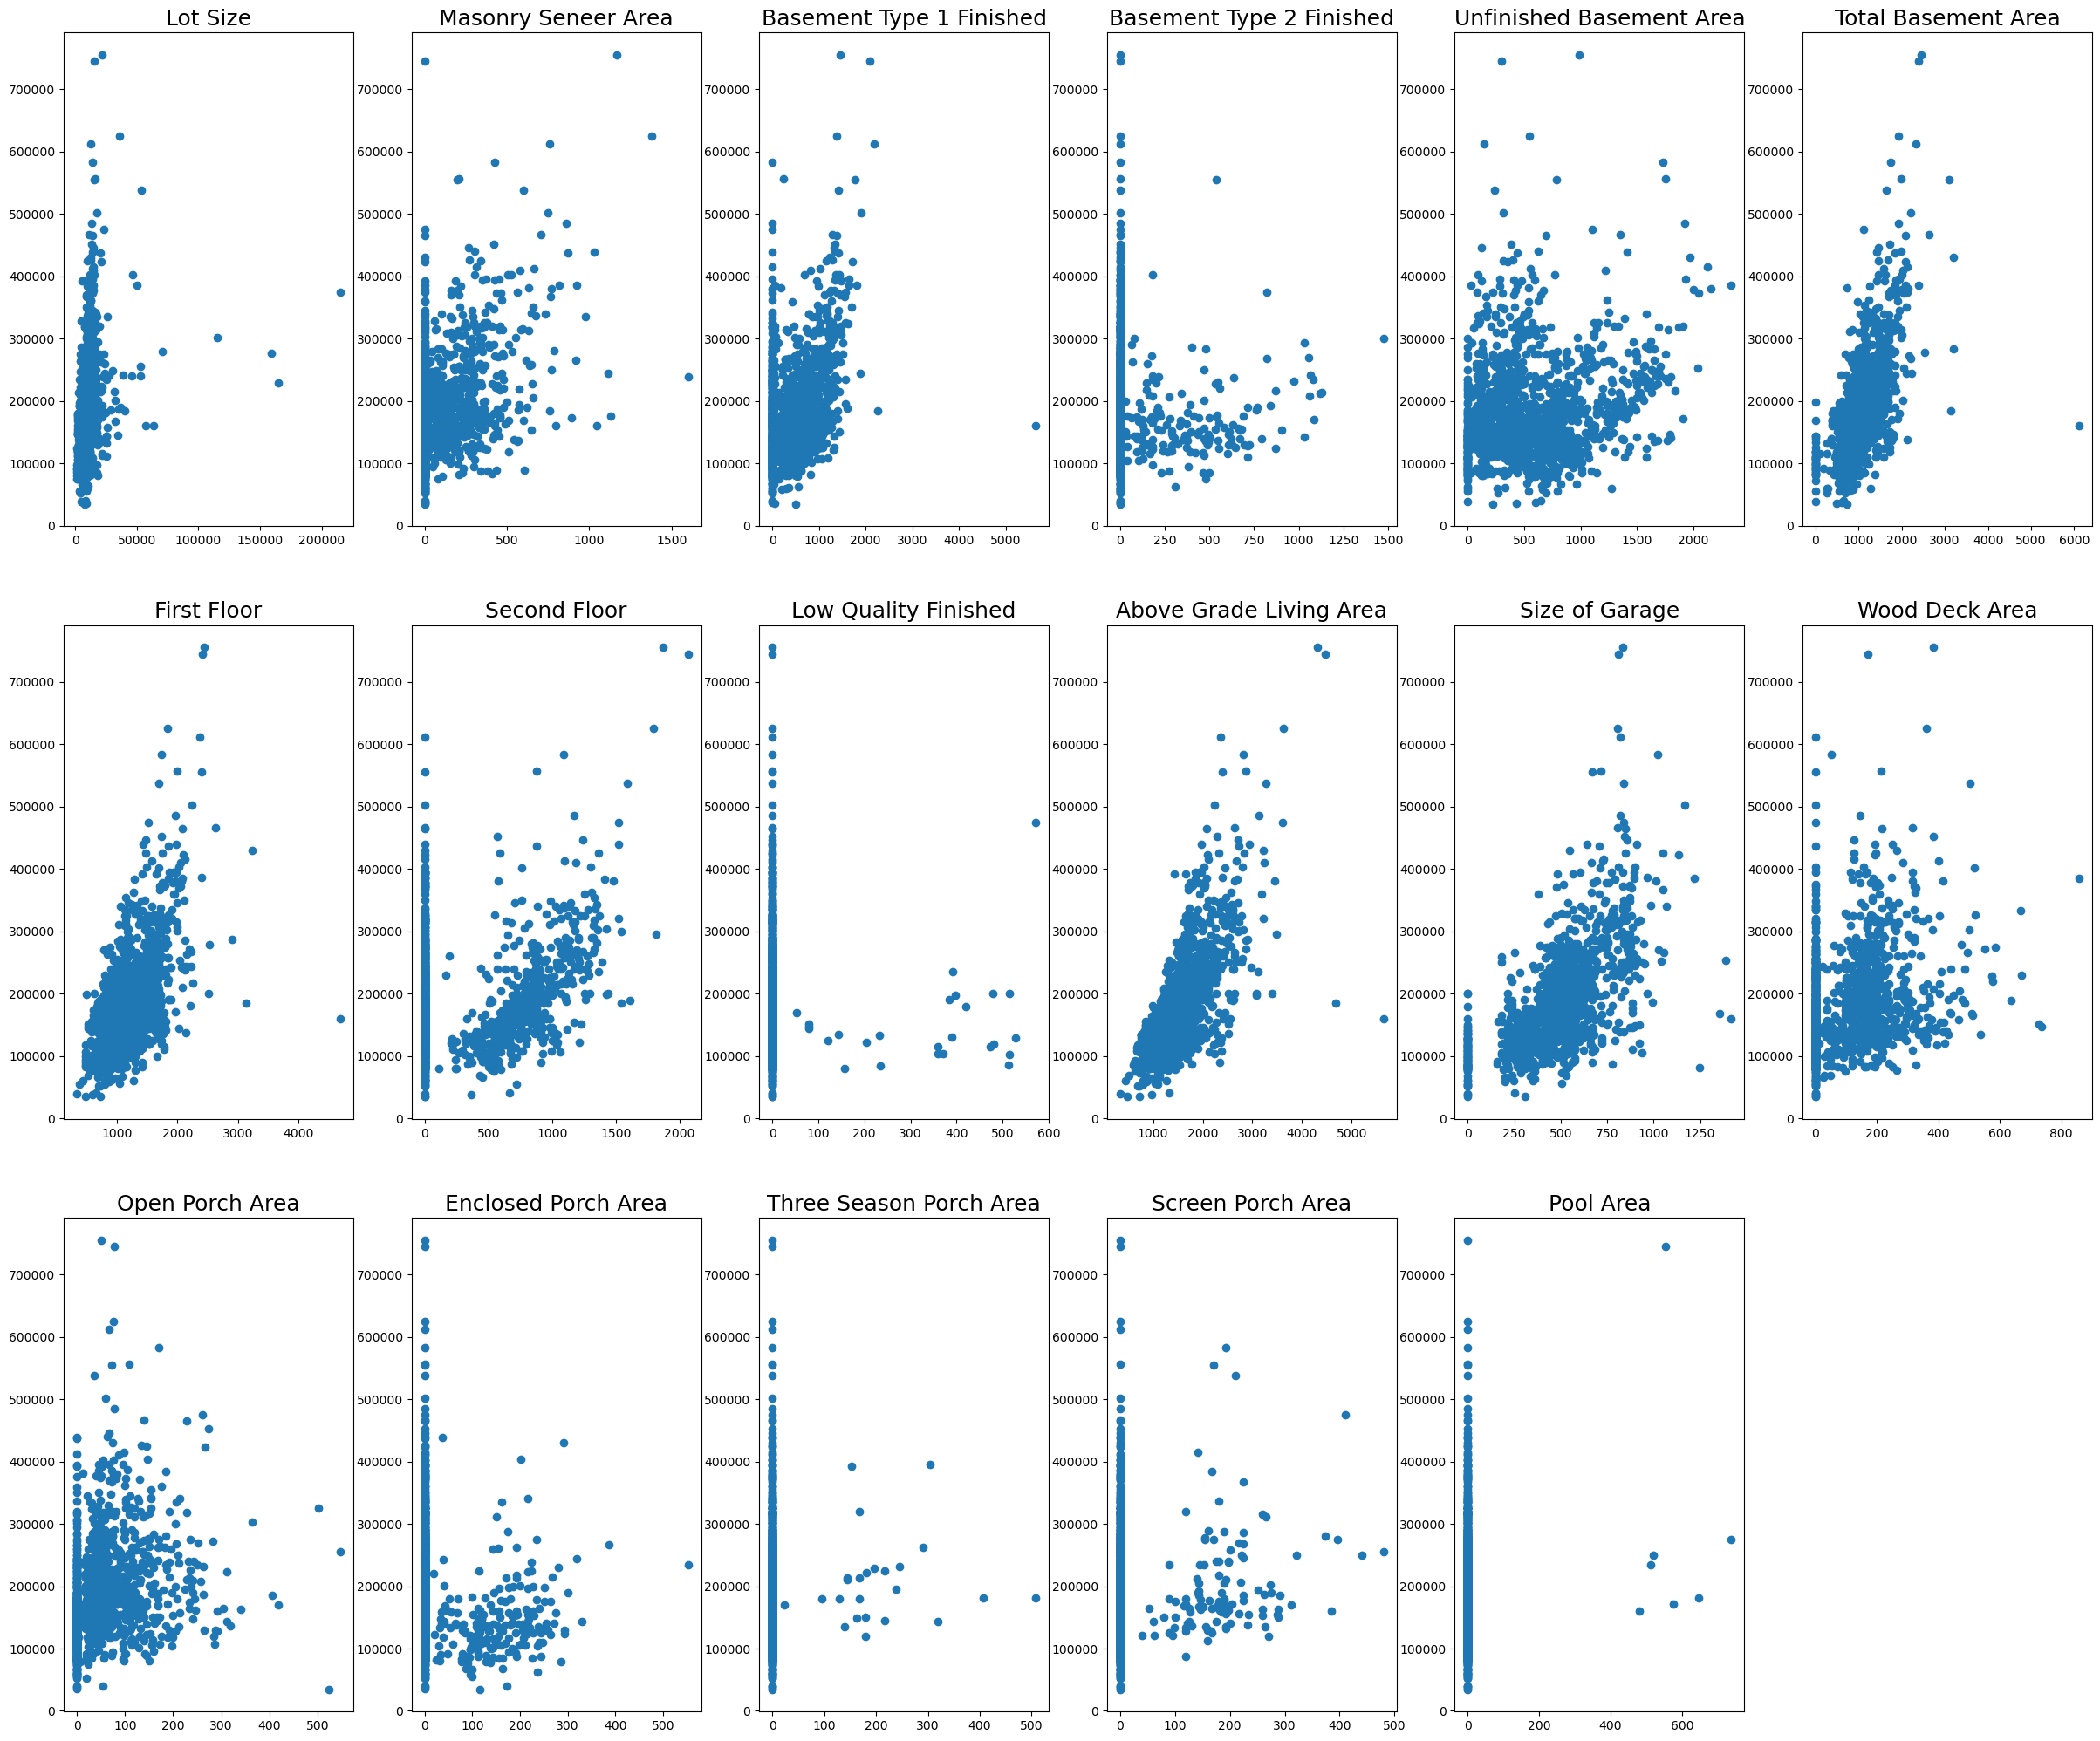

In [32]:
plt.figure(figsize=(30,25))
lables = ["LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2",
          "BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF",
          "LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF",
          "OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]
des = ["Lot Size","Masonry Seneer Area","Basement Type 1 Finished",
       "Basement Type 2 Finished","Unfinished Basement Area",
       "Total Basement Area","First Floor","Second Floor",
       "Low Quality Finished","Above Grade Living Area",
       "Size of Garage","Wood Deck Area","Open Porch Area",
       "Enclosed Porch Area","Three Season Porch Area","Screen Porch Area","Pool Area"]
col = 1

for i,j in zip(lables,des):
    if col<18:
        plt.subplot(3,6,col)
        plt.scatter(x=train[i], y=train["SalePrice"])
        plt.title(j, fontsize=18)
    col = col+1

It is clearly seen that there is positive correlation between price and areas i.e. if the area increases price will also increases expect 3SsnPorch (three season porch) and PoolArea.

## Neigborhood vs Sale Price

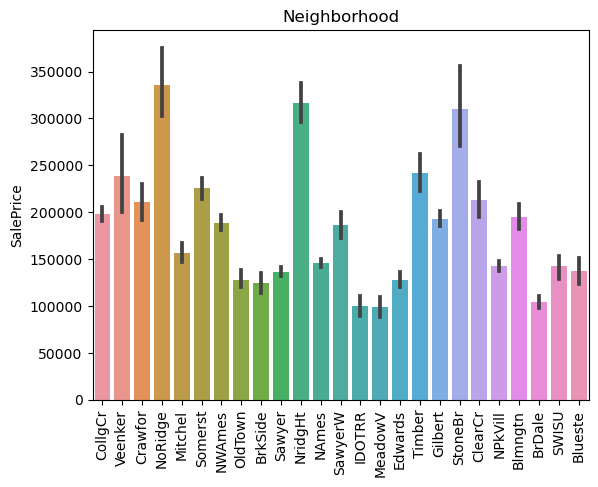

In [33]:
sns.barplot(x=train["Neighborhood"], y=train["SalePrice"]).set(xlabel=None)
plt.title("Neighborhood")
plt.xticks(rotation=90);

Note: We can see that the prices of the house having NoRidge, NridgHt, StoneBr and Timber neighborhoods are very high.

## Building type, House Style

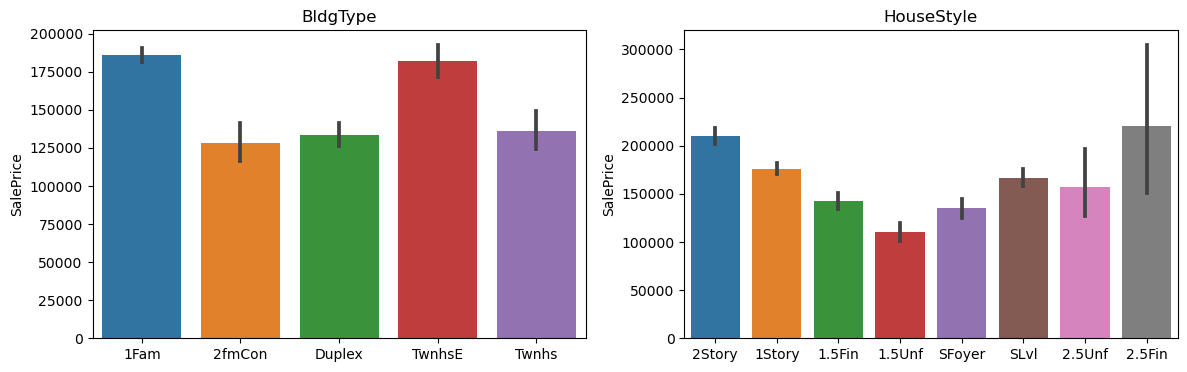

In [34]:
plt.figure(figsize=(14,4))
lables = ["BldgType","HouseStyle"]
col = 1

for i in lables:
    if col<3:
        plt.subplot(1,2,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

Note: Prices of the 1Fam (single-family detached) and TwnhsE (Townhouse End Unit) building type and 2.5Fin (two and one-half story: 2nd level finished) house style are very high.

## House Quality

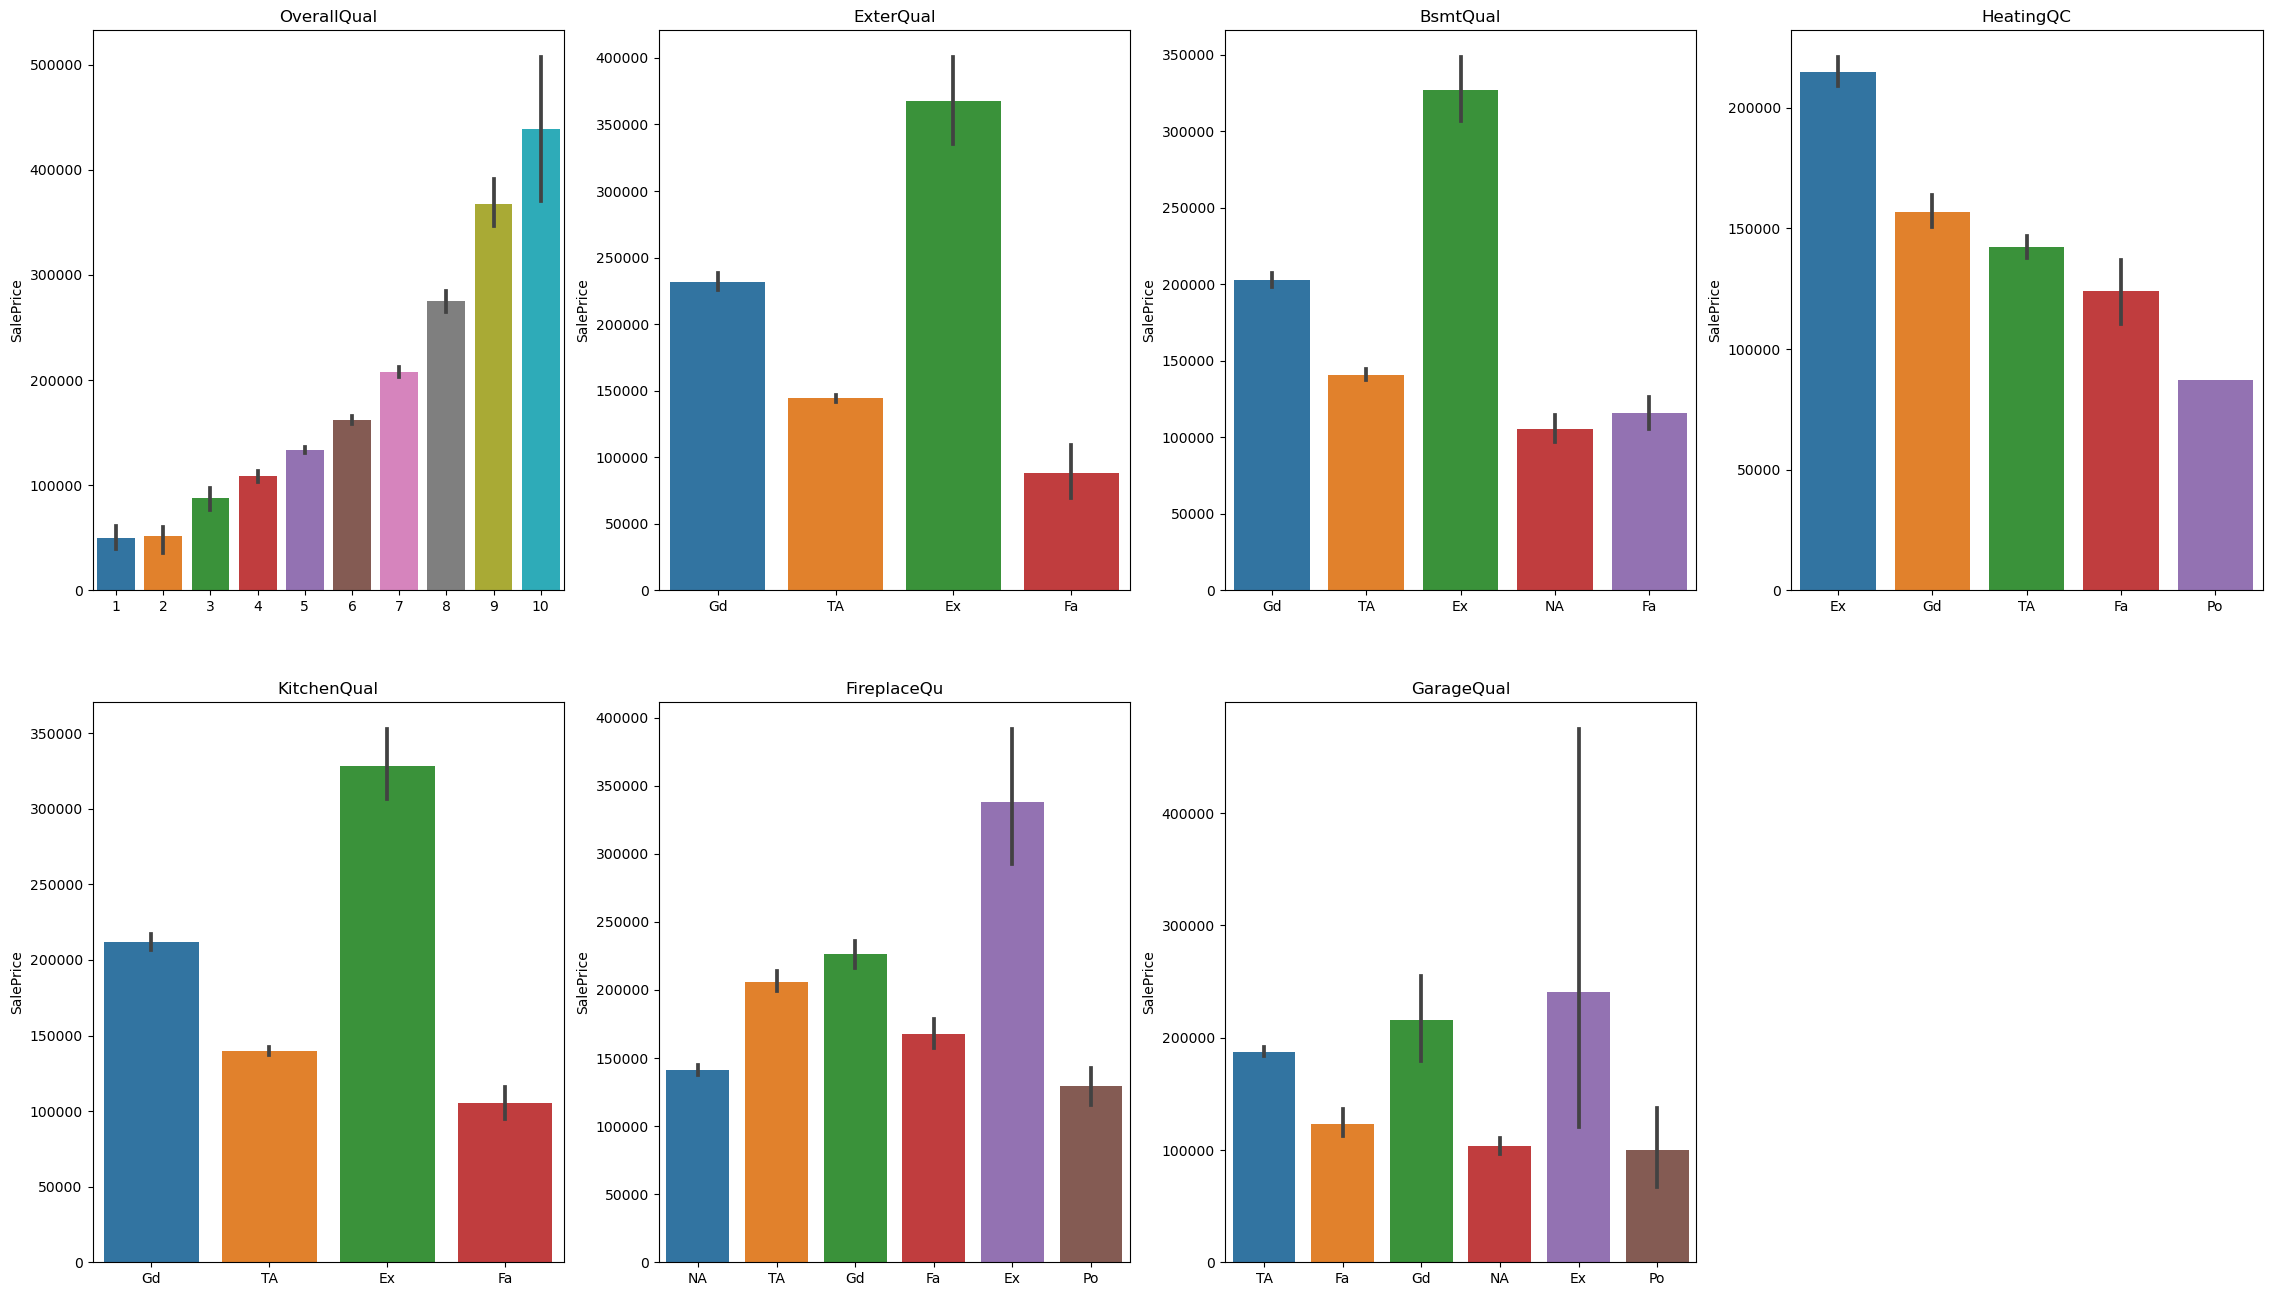

In [35]:
plt.figure(figsize=(28,16))
lables = ["OverallQual","ExterQual","BsmtQual","HeatingQC","KitchenQual","FireplaceQu","GarageQual"]
col = 1

for i in lables:
    if col<9:
        plt.subplot(2,4,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

Note: It can be seen that there is positive relation between quality and price. Price increases according to the quality.

## House condition

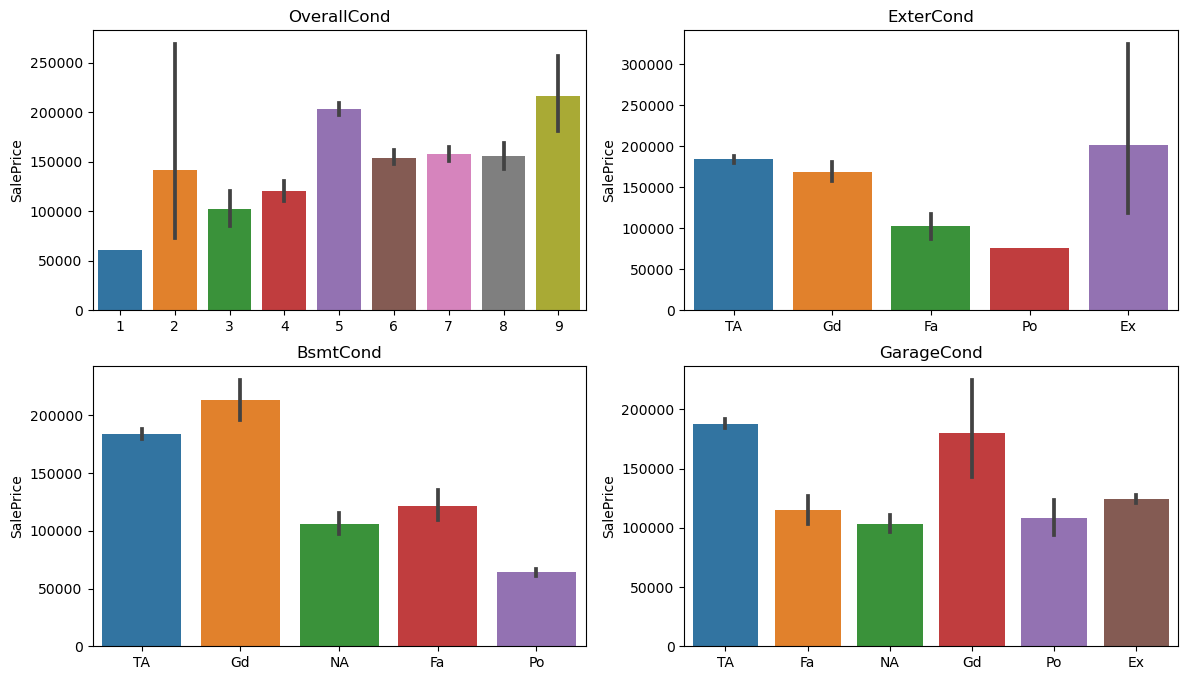

In [36]:
plt.figure(figsize=(14,8))
lables = ["OverallCond","ExterCond","BsmtCond","GarageCond"]
col = 1

for i in lables:
    if col<5:
        plt.subplot(2,2,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

Note: Prices of the house having Ex (excellent) and Gd (good) condition are very high.

## Bathroom condition

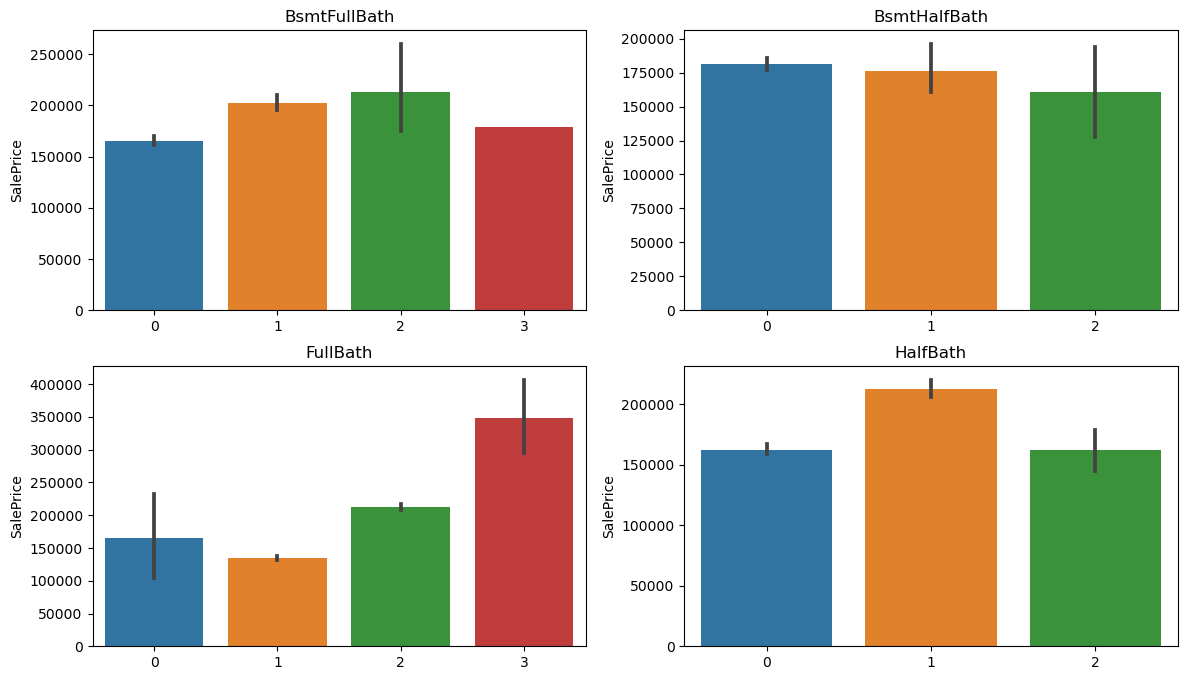

In [37]:
plt.figure(figsize=(14,8))
lables = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath"]
col = 1

for i in lables:
    if col<5:
        plt.subplot(2,2,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

## Roof style and material

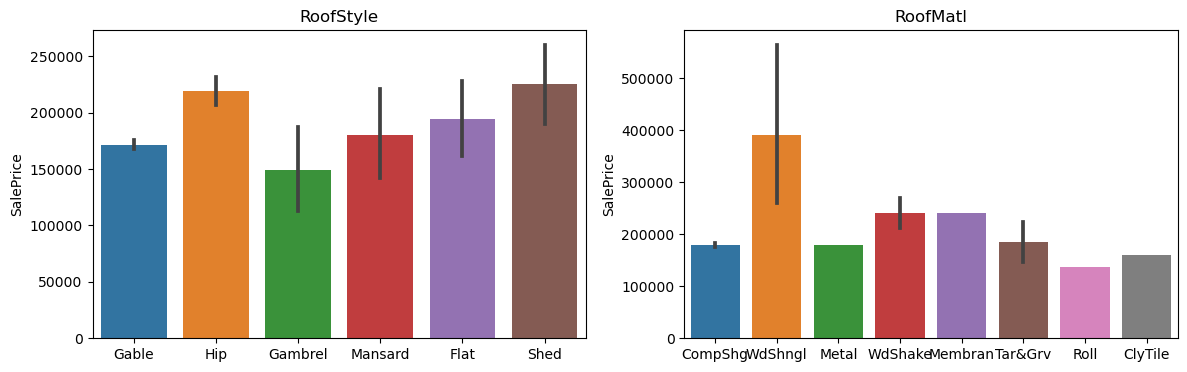

In [39]:
plt.figure(figsize=(14,4))
lables = ["RoofStyle","RoofMatl"]
col = 1

for i in lables:
    if col<3:
        plt.subplot(1,2,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

Note: Prices of the Shed roof type and WdShngl (wood shingles) roof material are very high.

## Basement

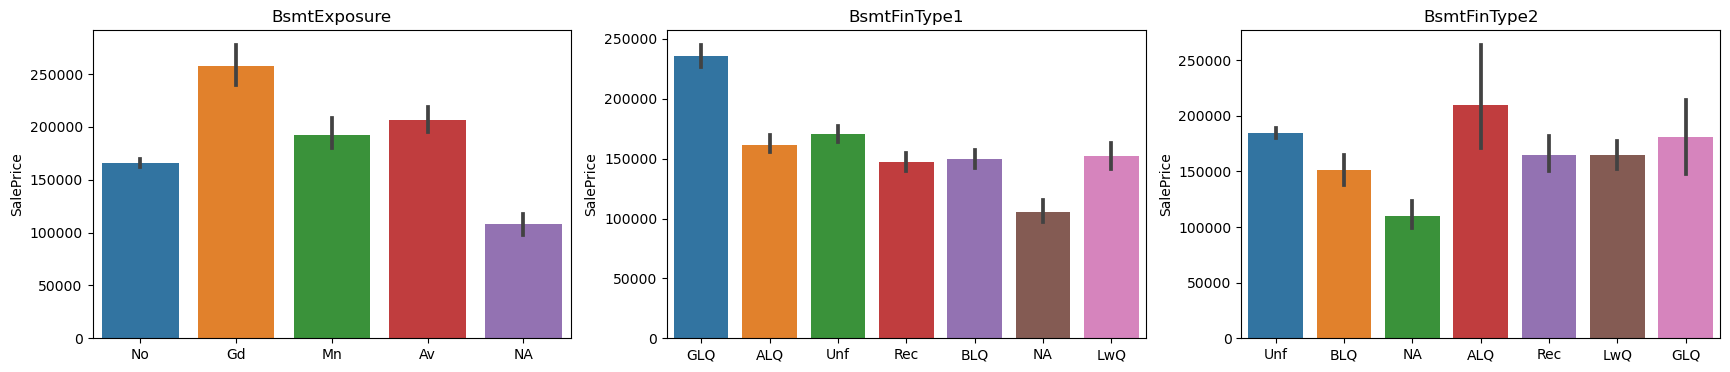

In [40]:
plt.figure(figsize=(21,4))
lables = ["BsmtExposure","BsmtFinType1","BsmtFinType2"]
col = 1

for i in lables:
    if col<4:
        plt.subplot(1,3,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

## Garage

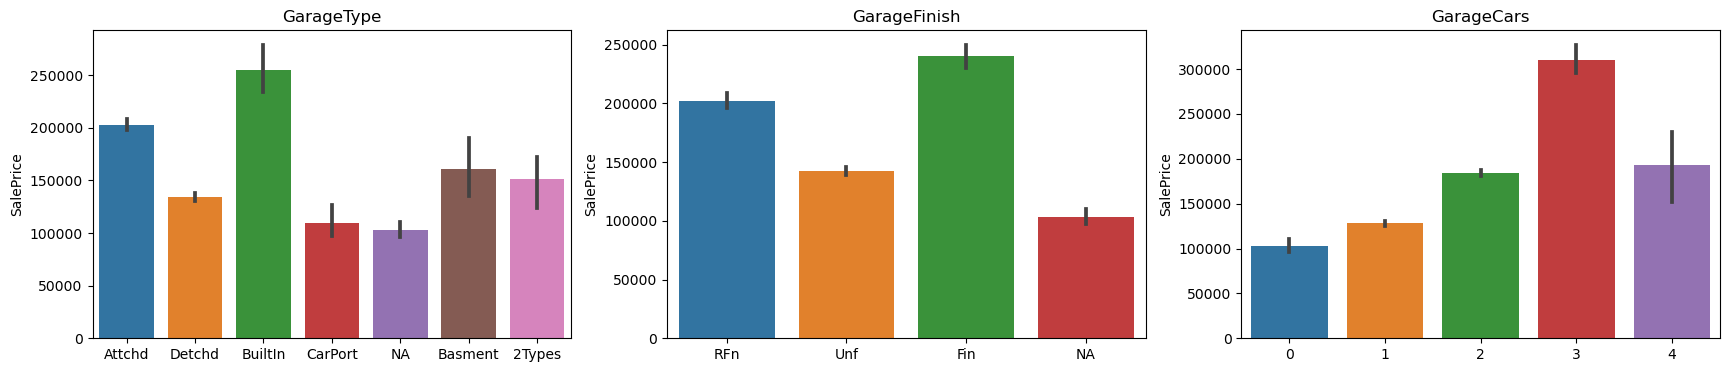

In [41]:
plt.figure(figsize=(21,4))
lables = ["GarageType","GarageFinish","GarageCars"]
col = 1

for i in lables:
    if col<4:
        plt.subplot(1,3,col)
        sns.barplot(x=train[i], y=train["SalePrice"]).set(xlabel=None)
        plt.title(i)
    col = col+1

## Month and Year of Sold

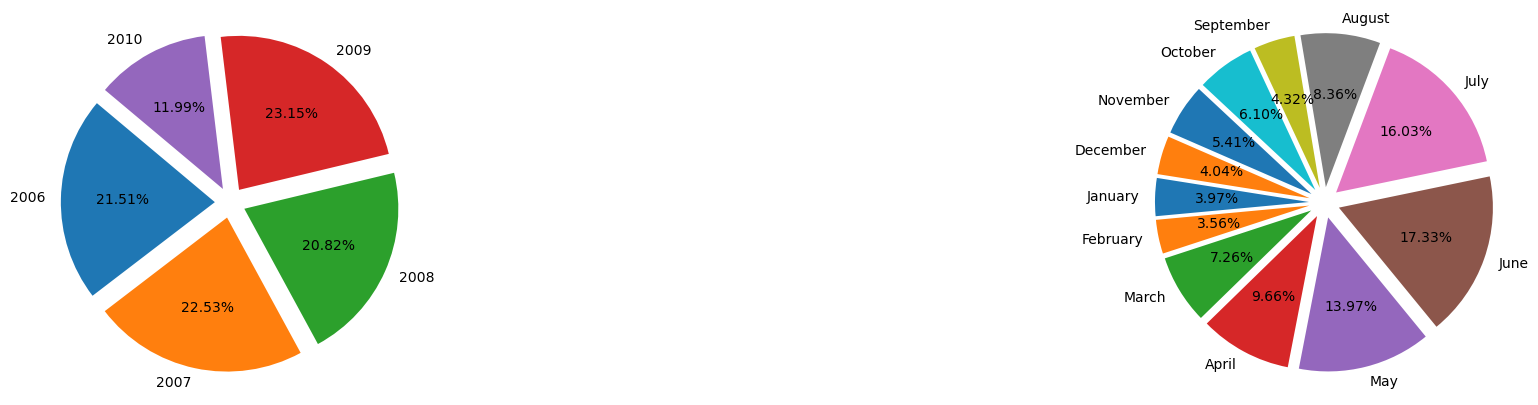

In [42]:
plt.figure(figsize=(20,5))
yearsold = list(range(2006,2011))
monthsold = ["January","February","March","April","May","June","July","August","September","October","November","December"]
years = train["YrSold"].value_counts().sort_index(ascending=True)
months = train["MoSold"].value_counts().sort_index(ascending=True)

plt.subplot(1,3,1)
plt.pie(years, labels=yearsold, explode=(0.1,0.1,0.1,0.1,0.1), autopct="%.2f%%", startangle=140)

plt.subplot(1,3,3)
plt.pie(months, labels=monthsold, explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1), autopct="%.2f%%", startangle=171);

Note:

Maximum houses were sold in year 2009 and in month of June.
We can also see a decline in sales from 2009 to 2010.

## Transform Skewed Features

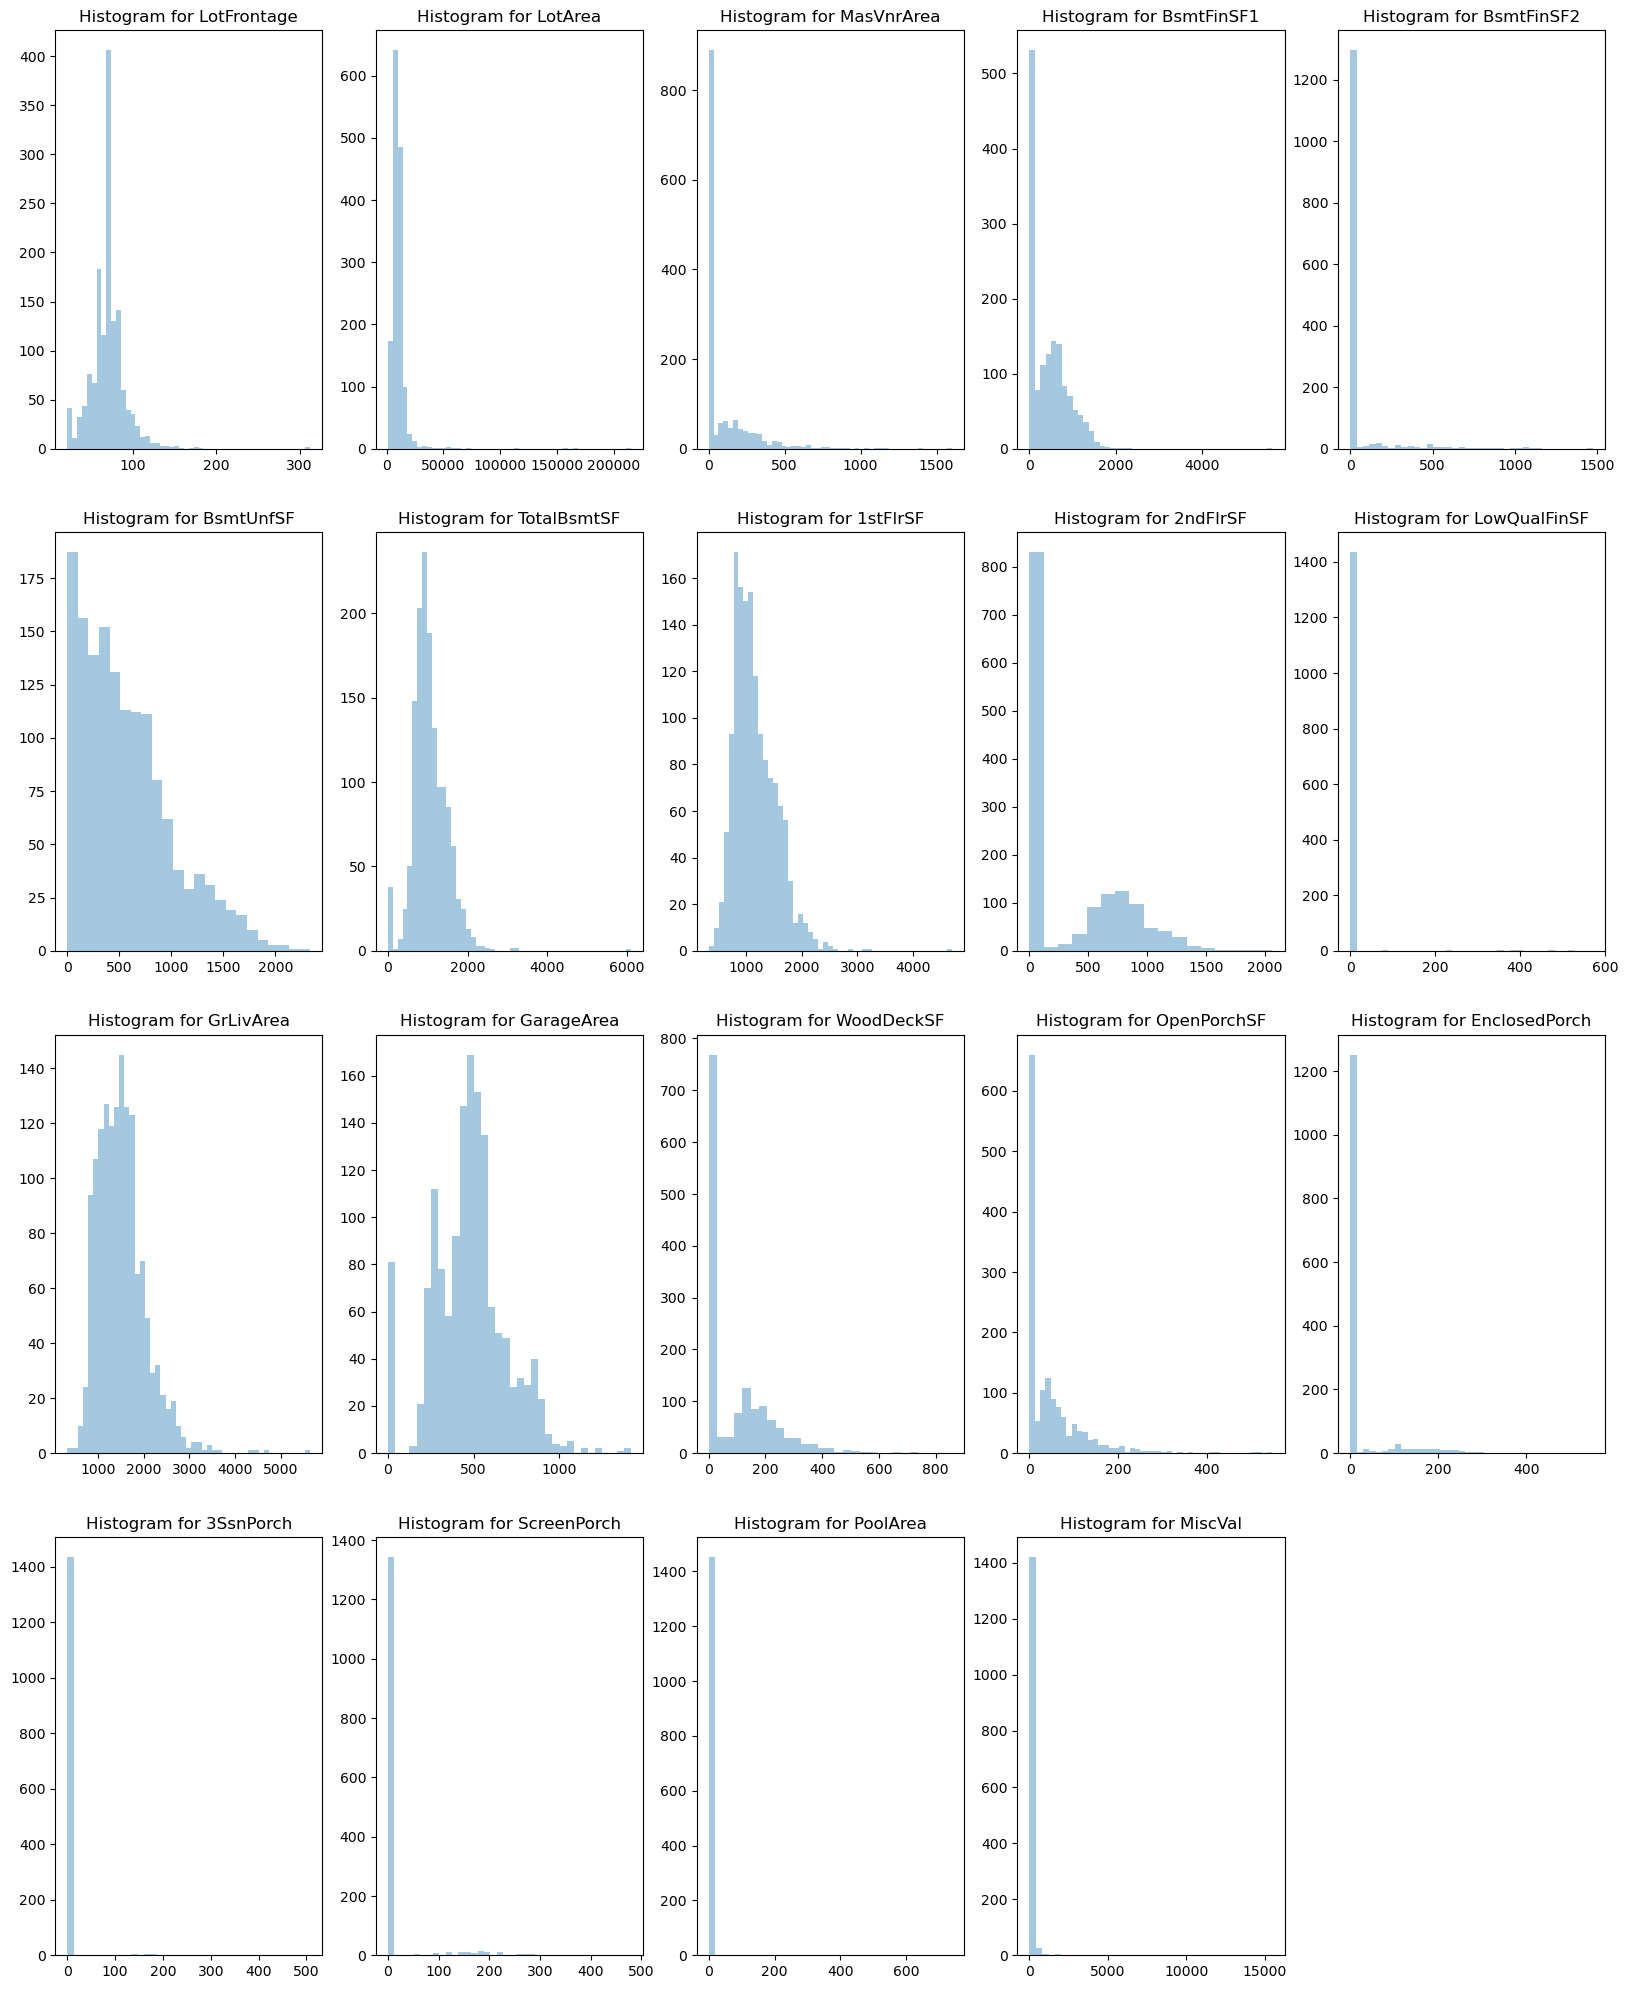

In [43]:
# Plot histogram for each continuous feature to see if a transformation is necessary
plt.figure(figsize=(20,25))
col = 1

for feature in train.columns:
    if train[feature].dtype!="object":
        if feature not in ["OverallQual","OverallCond","YearBuilt","YearRemodAdd","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageYrBlt","GarageCars","MoSold","YrSold","SalePrice"]:
            if col<21:
                plt.subplot(4,5,col)
                sns.distplot(train[feature], kde=False).set(xlabel=None)
                plt.title("Histogram for %s" % (feature))
            col += 1

## Box-Cox Power Transformation

In [44]:
# Transform skewed feature
train["LotFrontage"] = train["LotFrontage"].apply(lambda x:x**(1/3))
train["LotArea"] = train["LotArea"].apply(lambda x:x**(1/6))
train["MasVnrArea"] = train["MasVnrArea"].apply(lambda x:x**(1/1.5))
train["BsmtFinSF1"] = train["BsmtFinSF1"].apply(lambda x:x**(1/1.4))
train["BsmtUnfSF"] = train["BsmtUnfSF"].apply(lambda x:x**(1/1.5))
train["TotalBsmtSF"] = train["TotalBsmtSF"].apply(lambda x:x**(1/1.4))
train["1stFlrSF"] = train["1stFlrSF"].apply(lambda x:x**(1/4))
train["GrLivArea"] = train["GrLivArea"].apply(lambda x:x**(1/4.5))
train["GarageArea"] = train["GarageArea"].apply(lambda x:x**(1/1.1))
train["WoodDeckSF"] = train["WoodDeckSF"].apply(lambda x:x**(1/1.2))
train["OpenPorchSF"] = train["OpenPorchSF"].apply(lambda x:x**(1/2.5))

## Convert Categorical Features To Numeric

In [45]:
for feature in train.columns:
    if train[feature].dtype=="object":
        le = LabelEncoder()
        train[feature] = le.fit_transform(train[feature].astype(str))
        test[feature] = le.fit_transform(test[feature].astype(str))

## Split Into Train And Test Set

In [46]:
# Drop unnecccessary features and split into training/test sets
X = train.drop(["SalePrice"], axis=1)
y = train["SalePrice"]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize Features

In [47]:
# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [48]:
# Scale the training and test sets
features = X_train.columns

X_train[features] = scaler.transform(X_train)
X_test[features] = scaler.transform(X_test)

## Models
Let's build initial functions for the models.

In [49]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean().round(4)
    return rmse
    

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions).round(4)
    mse = mean_squared_error(y, predictions).round(4)
    rmse = np.sqrt(mean_squared_error(y, predictions)).round(4)
    r_squared = r2_score(y, predictions).round(4)
    return mae, mse, rmse, r_squared

In [50]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

## Linear Regression

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
ln_predictions = lin_reg.predict(X_test)


mae, mse, rmse, r_squared = evaluation(y_test, ln_predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(lin_reg)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "LinearRegression","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 20744.5318
MSE: 1094405681.7948
RMSE: 33081.8029
R2 Score: 0.8573
------------------------------
RMSE Cross-Validation: 32966.3379


## Decision Tree

In [52]:
d_tree = DecisionTreeRegressor()
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(lin_reg)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "DecisionTree","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 25291.0788
MSE: 1393048409.3596
RMSE: 37323.5637
R2 Score: 0.8184
------------------------------
RMSE Cross-Validation: 32966.3379


## Random forest

In [53]:
random_forest = RandomForestRegressor(n_estimators=250)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(random_forest)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "RandomForest","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 17155.3073
MSE: 813758110.0321
RMSE: 28526.4458
R2 Score: 0.8939
------------------------------
RMSE Cross-Validation: 29764.092


## Support Vector Regression

In [54]:
svr = SVR(C=100000)
svr.fit(X_train, y_train)
predictions = svr.predict(X_test)

mae, mse, rmse, r_squared = evaluation(y_test, predictions)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(svr)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "SVR","MAE": mae, "MSE": mse, "RMSE": rmse, "R2 Score": r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

MAE: 19881.2195
MSE: 1766272245.6568
RMSE: 42027.0418
R2 Score: 0.7697
------------------------------
RMSE Cross-Validation: 51578.6676


## OLS

In [58]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression()

ols_model.fit(X_train, y_train)

predictions_ols = ols_model.predict(X_test)

mae_ols, mse_ols, rmse_ols, r_squared_ols = evaluation(y_test, predictions_ols)
print("OLS MAE:", mae_ols)
print("OLS MSE:", mse_ols)
print("OLS RMSE:", rmse_ols)
print("OLS R2 Score:", r_squared_ols)
print("-" * 30)

rmse_cross_val_ols = rmse_cv(ols_model)
print("OLS RMSE Cross-Validation:", rmse_cross_val_ols)

new_row_ols = {"Model": "OLS", "MAE": mae_ols, "MSE": mse_ols, "RMSE": rmse_ols, "R2 Score": r_squared_ols, "RMSE (Cross-Validation)": rmse_cross_val_ols}
models = models.append(new_row_ols, ignore_index=True)


OLS MAE: 20744.5318
OLS MSE: 1094405681.7948
OLS RMSE: 33081.8029
OLS R2 Score: 0.8573
------------------------------
OLS RMSE Cross-Validation: 32966.3379


## Final comparison and summary

In [57]:
models.sort_values(by="RMSE")

,Model,MAE,MSE,RMSE,R2 Score,RMSE (Cross-Validation)
2,RandomForest,17155.3073,8.137581e+08,28526.4458,0.8939,29764.0920
0,LinearRegression,20744.5318,1.094406e+09,33081.8029,0.8573,32966.3379
4,OLS,20744.5318,1.094406e+09,33081.8029,0.8573,32966.3379
1,DecisionTree,25291.0788,1.393048e+09,37323.5637,0.8184,32966.3379
3,SVR,19881.2195,1.766272e+09,42027.0418,0.7697,51578.6676
